In [305]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import pairwise_distances


In [306]:
def gen_data(no_data, center_point, sd=0.1, dim=2):
    cov = np.diag([sd]*dim)
    return np.random.multivariate_normal(center_point, cov, no_data)

In [307]:
centers = [(-0.5,-0.2),(0,0.6),(0.5,0)]
training_data = []
for i in range(3):
    new_data = gen_data(30, centers[i] )
    training_data.append(new_data)
training_data = np.concatenate(training_data)

In [308]:
training_data.shape

(90, 2)

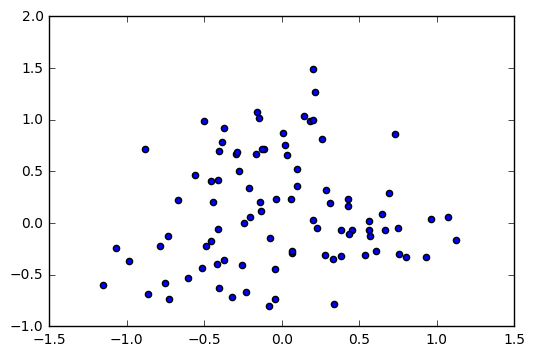

In [309]:
plt.scatter(training_data[:,0], training_data[:,1])

## b) Compute RBF Kernel

In [310]:
sd = 0.1
distance = pairwise_distances(training_data)
def computeRBF(data):
    return np.exp(-data/(2*sd**2))

training_rbf = computeRBF(distance) # now data span on 90 dimensions

print(training_rbf.shape)

(90, 90)


In [311]:
def centerize( df ):
    mean = np.mean( df, axis = 0 )
    centered = df - mean 
    return (centered, mean)

class PCA:
    def __init__(self, X):
        # X's shape (items,dimensions)
        (centered, self.means) = centerize(X)
        cov = np.cov( centered.T )

        (eig_values, eig_vectors) = np.linalg.eig(cov)

        eig_idx = np.argsort(-eig_values)
        (self.eig_values, self.eig_vectors) = (eig_values[eig_idx], eig_vectors[:,eig_idx])
        
    def project(self, X):
        # X's shape (items,dimensions)
        X = X - self.means
        return np.dot(X, self.eig_vectors)
    
    def reconstruct(self, X, eig_vectors_idx):
        res = np.dot( X, self.eig_vectors[:, eig_vectors_idx].T )
        res = res.T + self.means.reshape(len(self.means),1)
        return res.T

In [312]:
myPCA = PCA(training_rbf)

In [313]:
myPCA.eig_values[:5]

array([ 0.02392108,  0.02333916,  0.01987518,  0.01766689,  0.01369421])

In [314]:
myPCA.eig_vectors[0].shape

(90,)

## c) Visulize first 8 PCs in the 2-dimensional input

In [334]:
grid_space = 1.5
delta = 0.005

x = np.arange(-grid_space, grid_space + delta, delta)
y = np.arange(-grid_space, grid_space + delta, delta)
X, Y = np.meshgrid(x, y)

grid_points = len(X)
print(X.shape)
print(np.max(Y))

(601, 601)
1.5


In [335]:
test_data = np.hstack([X.reshape((grid_points**2,1)),Y.reshape((grid_points**2,1))])
print(test_data.shape)

(361201, 2)


In [336]:
test_data_rbf = list(map(lambda x: spanOnRBFDims(x, training_data), test_data ))
test_data_rbf = np.array(test_data_rbf).reshape( (len(test_data),90) )

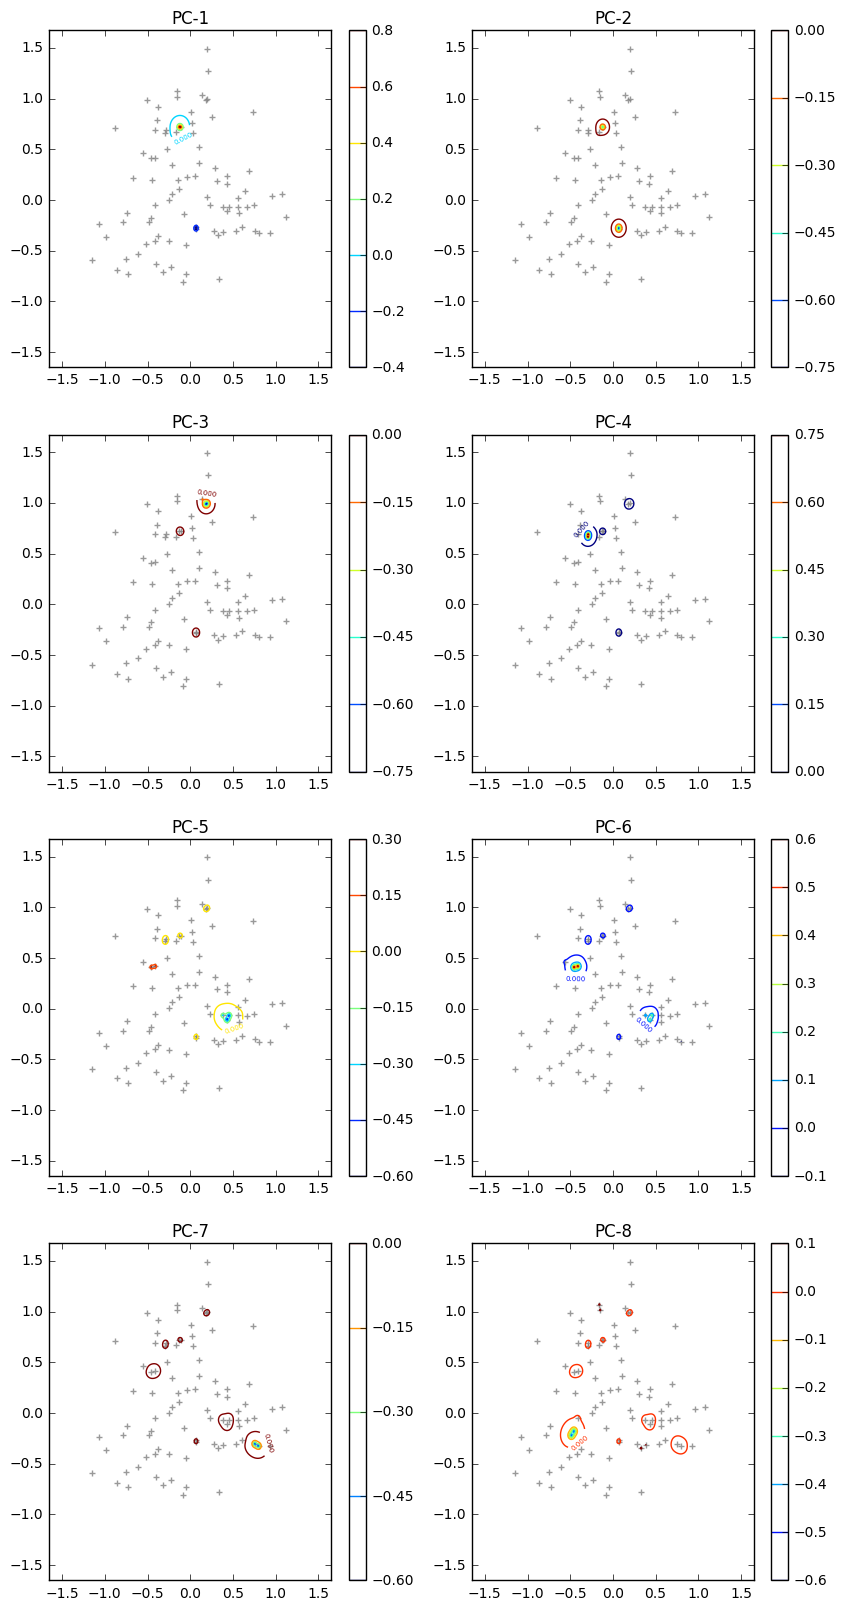

In [337]:
plt.figure(figsize=(10,20))
for i in range(8):
    Z = myPCA.project(test_data_rbf)[:,i].reshape((grid_points,grid_points))
    plt.subplot(4,2,i+1)
#     plt.imshow(Z, extent=[-grid_space, grid_space, -grid_space, grid_space])
    ct = plt.contour(X,Y,Z)
    plt.clabel(ct, inline=1, fontsize=5)
    plt.colorbar()
    plt.title("PC-%d" % (i+1))
    plt.scatter(training_data[:,0], training_data[:,1], color='grey', marker='+', alpha=0.8)

### Interpret the result
From the plots, we can see that PC-1 contains only few contour islands and the numbers increase as we move to other PCs. The fewer contour islands, the less variation in that dimension.

## d) Discuss for which applications Kernel-PCA might be suitable.

Kernel-PCA is suitable for applications that its data poses non-linearlity dependency. One of the examples is this exercise that we have data roughly seperate into 3 groups. If we apply PCA directly, we won't get any good representation dimension. This cliam is verified by looking the variance before and after projection onto PCs space. They are quite the same value.

In [340]:
d_pca = PCA(training_data)

In [341]:
d_pca.eig_vectors

array([[-0.38966548, -0.92095647],
       [-0.92095647,  0.38966548]])

In [359]:
print("Difference in var before and after projection onto PCS space")
d_pca.eig_values - np.var(training_data,axis=0)

Difference in var before and after projection onto PCS space


array([ 0.04454323, -0.03839466])

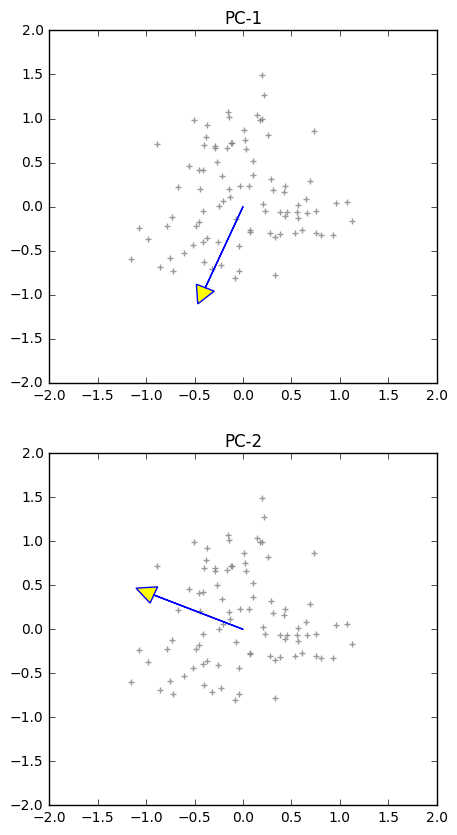

In [353]:
plt.figure(figsize=(5,10))
for i in range(2):
    plt.subplot(2,1,i+1)
    plt.scatter(training_data[:,0], training_data[:,1], color='grey', marker='+', alpha=0.8)
    plt.arrow(0, 0, d_pca.eig_vectors[0,i], d_pca.eig_vectors[1,i], head_width=0.2, head_length=0.2, fc='yellow', ec='blue', label="PC-1")
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.title("PC-%d" % (i+1))